## FRI Lab 4: Aperture Photometry with Python

Last week you created master dark and flat calibration frames and used them to fully reduce over two thousand science images. Now that these images are suited for scientific measurement, we are ready to perform aperture photometry. ** Note: if you were not able to succesfully reduce the science frames from last week, you need to finish that before beginning this lab. **

We don't want you to labor unnecessarily over the details of measuring the aperture photometry, so we provide the code for the most complicated first steps below. We do want you to understand the measurements that are performed, and we need you to help with the filenames, so please carefully read and modify the cells below as you evaluate them. Like in the last lab, there are embedded questions highlighted <mark>like this</mark> that we ask you to respond to on the quiz associated with this lab on Canvas.

The provided code will calculate aperture photometry for the science target and a comparison star for every image with a bunch of different aperture sizes. This returns a large numpy array that you will have to manipulate to decide which aperture size is optimal and to write out a final light curve for further analysis next week.

All the data analysis will be done in a Jupyter notebook. To start, download from the class Canvas page the file *AST 210K > Files > Labs > lab4 > Lab4.ipynb*. Place it in the directory that contains your science data from last week; this may be your "lab3" directory from last week. Next, use the Terminal to cd into this directory and type "jupyter notebook", and then select "Lab4.ipynb". From there, follow the instructions in this notebook (the file you are currently reading is a PDF copy of that notebook).

We start by importing all the tools we will need for the lab. You'll see how each of these is used later on.

In [1]:
# for handling arrays; image data are arrays!
%matplotlib notebook
import numpy as np 
# for plotting and displaying data
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
# for making lists of filenames
from glob import glob 
# for reading and writing FITS format data
from astropy.io import fits 
# for doing aperture photometry:
import photutils
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from astropy.stats import mad_std
# Import a function for fitting data
from scipy.optimize import curve_fit
# need to manually trigger garbage collector to free memory
import gc
# display figures in this notebook.
# we're going to use some more interactive/updatable
# plots in this lab with a different "magic" command
from IPython import display

# This tests to see if you have the same version as the PMA macs
PMA_macs = photutils.__version__ == '0.5' 

To show how aperture photometry is measured, we will demonstrate in detail on a single reduced image of your time series sequence. Then we will loop through your entire image sequence and construct a "light curve" by performing aperture photometry on every frame.

Note that you may need to edit the location and filename of your first frame in the next cell.

Also note the explicit call to a numbered plt.figure().  With "%matplotlib notebook," the plots are not static and can be updated.  You will need to define your own plt.figure().

<IPython.core.display.Javascript object>


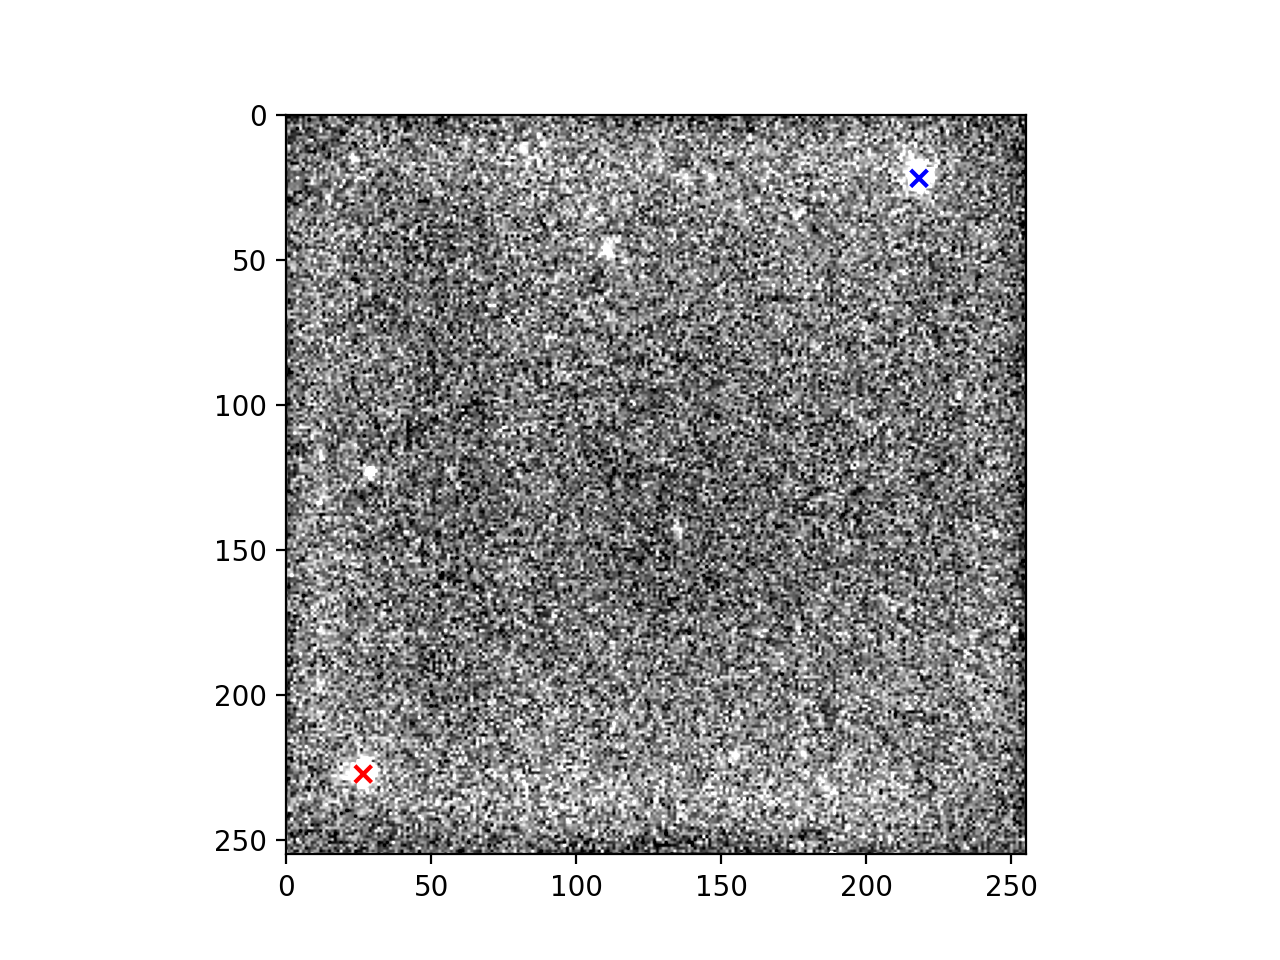

In [2]:
# Filename of example frame relative to your current directory (you may need to edit)
firstfilename = 'ktwo220274129/ktwo220274129-0001c.fits'

# load the data
firstframe = fits.getdata(firstfilename)

# display the image
plt.figure(1) #Create new "figure" for this image
plt.imshow(firstframe,cmap='gray',vmin=np.percentile(firstframe,5),
           vmax=np.percentile(firstframe,98))
plt.xlim(0,255)
plt.ylim(255,0)
plt.show()

If you squint, you might be able to see a handful of stars in this image, but only two are bright enough to yield decent measurements. Our science target is in the upper right corner and we will use the star in the bottom left as our comparison star.

One of the trickiest parts of aperture photometry is locating the stars in the image. The function DAOStarFinder can search for all star-like features in an image, but it has to be carefully tuned or it will do a poor job. We have tried to set appropriate values for this specific data set here.

Since we don't want to get confused by spurious detections, we specify the *approximate* known locations of the target and comparison stars, and only do photometry on sources near the expected parts of the image.

In [3]:
# First thing we need to know is how much scatter is in the "background"
# counts so that we don't detect random background fluctuations as stars.
bkg_sigma = mad_std(firstframe)

# We also need to guess the full-width at half maximum (FWHM) for the 
# stars to guide our search, which we will verify in a later step.
daofind = DAOStarFinder(fwhm=1.5, threshold=10.*bkg_sigma)
sources = daofind(firstframe) 
sources #display results

<QTable length=2>
  id      xcentroid      ...        flux                mag        
int64      float64       ...      float64             float64      
----- ------------------ ... ------------------ -------------------
    1 218.24772250299296 ... 20.149090524245093 -3.2606386200866395
    2 26.502343775945576 ... 26.684260418844346  -3.565637925993487

In [4]:
# Depending on the image you chose, there will be two or more results.
# The target is near (x,y) = (218,22) and the comp star is near (27,227)

# We will check for each frame which detected "star" is nearest to these 
# coordinates to validate the detections.

# Target coordinates:
tx,ty = (218,22)
# Comparison star coordinates:
cx,cy = (27,227)

# Define function that returns the distance, in pixels, between two points:
def distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2.+(y1-y2)**2.)

# Set up empty arrays to hold distances of detections from approximate locations
numsources = len(sources)
tdist = np.zeros(numsources)
cdist = np.zeros(numsources)
# Populate arrays with distances for each source
for i,row in enumerate(sources):
    tdist[i] = distance(tx,ty,row["xcentroid"],row["ycentroid"])
    cdist[i] = distance(cx,cy,row["xcentroid"],row["ycentroid"])
    
# Identify the row indices of the target and comp stars in "sources"
tind = np.argmin(tdist)
cind = np.argmin(cdist)
print('Target index: {}. Comp index: {}.'.format(tind,cind))

# Replace "sources" with just target and comparison, in that order:
sources = sources[[tind,cind]]

Target index: 0. Comp index: 1.


In [5]:
# Let's show where those detections are on the image...
# NOTE: These points will be added to the image that was
# already displayed ABOVE. Scroll back to that figure 
# to see the changes. 
plt.figure(1) # same figure from three cells up
plt.imshow(firstframe,cmap='gray',vmin=np.percentile(firstframe,5),
           vmax=np.percentile(firstframe,95))
# Blue is target, red is comparison star.
plt.scatter(sources['xcentroid'],sources['ycentroid'],c=['blue','red'],
            marker='x')
plt.show() # Above

As we mentioned, finding the stars automatically is one of the hardest parts of this process. Once we know where the stars are, we can measure them.

The next cell is a bit complicated, but we want you to see the output so that you understand what a star looks like in an image, and how we go about measuring its brightness. We will create a plot of pixel brightness as a function of distance from the detected target centroid. We will then fit a function to the stellar profile to characterize the "seeing" (how spread out the light from the star is in our image) and we will demonstrate the parts of the stellar profile that are measured by our aperture photometry.

We quantify "seeing" by the "full width at half maximum" (FWHM) of the stellar profile, which is twice the radial distance from the center where the starlight has dropped by half relative to the peak value.  We fit a Gaussian function to the stellar profile to determine this value.

The x-axis on the bottom of the figure is in units of pixels, while the top axis gives distance in units of arcseconds (angular distance on the sky).  There are 60 arcseconds in an arcminute, 60 arcminutes in a degree, and 360 degrees in a full circle.

The dashed vertical lines in the figure show the different aperture sizes that we will perform photometry with. We don't generally know the best aperture size to use for measuring the relative brightness of a star in an image, so we sample a range and determine empirically which one yields the best light curve.  The hatched region shows the location of the sky annulus (ring) where we assess the average local background counts that we will subtract out of our star aperture.  This should be safely outside the stellar profile, which you can confirm in this figure.

<IPython.core.display.Javascript object>


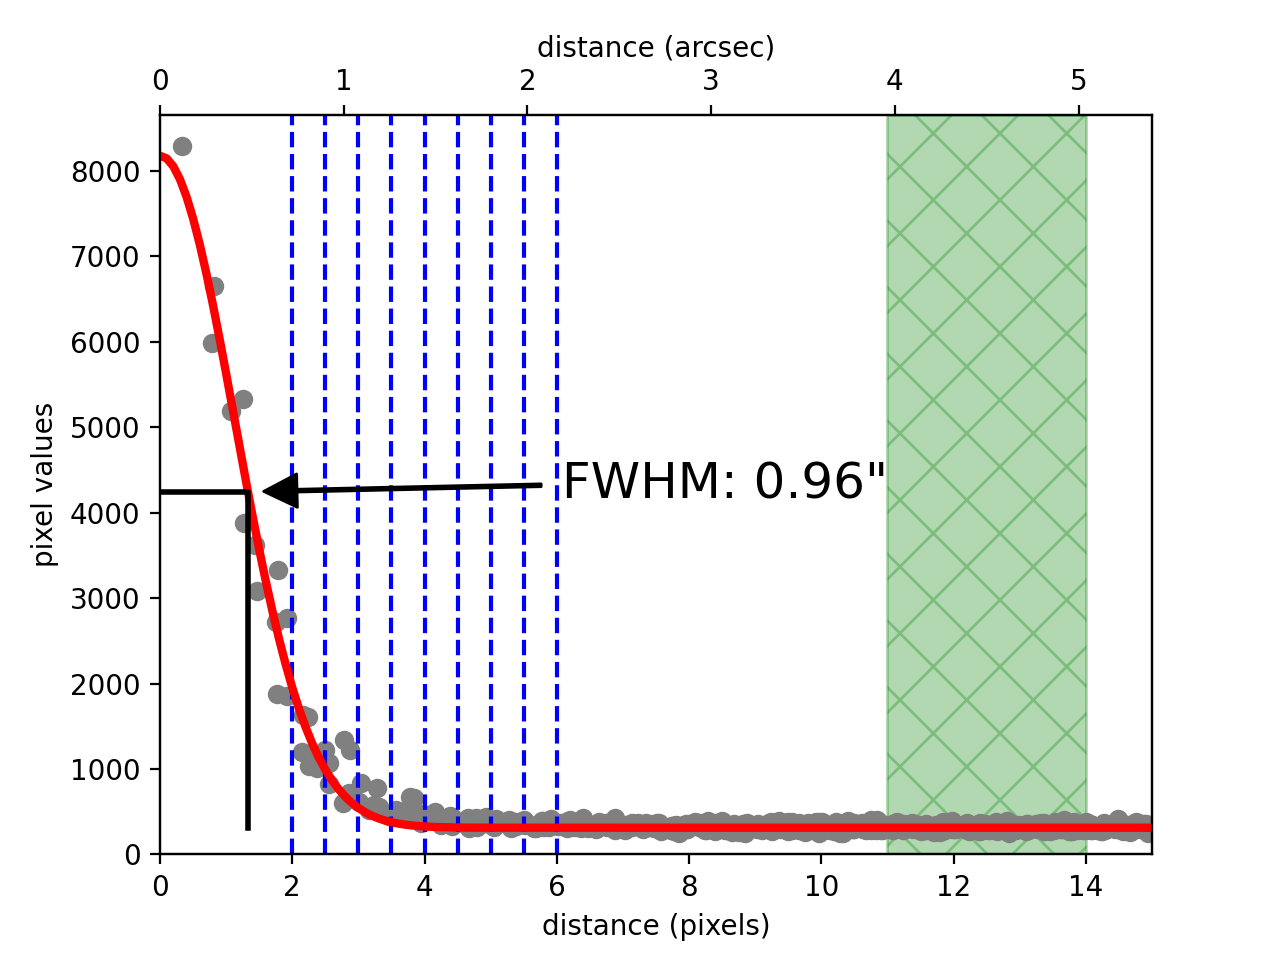

Seeing in the first frame is 0.9575990722356257"
Aperture sizes (in pixels) to test: [2.  2.5 3.  3.5 4.  4.5 5.  5.5 6. ]


In [6]:
# Visualize the target star profile.

# Define the Gaussian function for fitting the stellar profile
def gaussian(x, A, sigma):
    # Definition of a Gaussian where:
    # - x is distance from center
    # - A is amplitude
    # - sigma is stddev
    # (FWHM = 2.3548*sigma)
    return A*np.exp(-(x)**2/(2.*sigma**2))

# Usually we want to know seeing in units of angle on the sky
# rather than in number of pixels. So we need the plate scale
# of the ProEM Camera on the McDonald 82" telescope:
platescale = 0.36 # arcsec / pixel

# Plot the pixel values in terms of distance from the
# center of the first star for pixels within ~15 of the pixels
x0 = sources['xcentroid'][0] # x center of target star
y0 = sources['ycentroid'][0] # y center of target star
pdist = 15 #distance in pixels to examine
dist = [] #empty list to hold pixel distances
pval = [] #empty list to hold pixel values
for x in np.arange(round(x0)-pdist,round(x0)+pdist):
    for y in np.arange(round(y0)-pdist,round(y0)+pdist):
        dist.append(distance(x,y,x0,y0))
        # It bothers me that the image is indexed as (y,x)
        pval.append(firstframe[int(y),int(x)])

# Plot the results (in units of pixels) in a new figure
fig, ax1 = plt.subplots()
ax1.scatter(np.array(dist),pval,c='gray')
ax1.set_xlim(0,pdist)
ax1.set_xlabel('distance (pixels)')
ax1.set_ylabel('pixel values')

#Make a second x-axis with arcsec units
ax2 = ax1.twiny()
ax2.set_xlabel('distance (arcsec)')
ax2.set_xlim(0,pdist*platescale)


# Find a Gaussian curve of best fit to the observed stellar
# profile above the median image background (the scipy.optimize 
# functions are great for fitting data!)

# "Typical background"
bkgmed = np.median(firstframe.flatten())
p0=[10000.,1.] #initial guesses of height and sigma
popt,_  = curve_fit(gaussian,dist,np.array(pval)-bkgmed,p0=p0)
fwhm = np.abs(popt[-1])*2.3548*platescale
print("Seeing in the first frame is "+str(fwhm)+'"')

# Plot this best fit
gsamplespacing = 0.1
gsample=np.arange(0,pdist+gsamplespacing,gsamplespacing)
ax2.plot(gsample*platescale,bkgmed+
         gaussian(gsample,popt[0],popt[1]),c='r',lw=3)
# And show the HWHM
ax2.plot([0,fwhm/2.,fwhm/2.],[bkgmed+(popt[0]/2.),bkgmed+(popt[0]/2.),bkgmed],
         c='black',ls='-',lw=2)
ax2.annotate('FWHM: {:.2f}"'.format(fwhm), xy=(fwhm/2.,bkgmed+popt[0]/2.), 
             xycoords='data',xytext=(0.57,0.5), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05,width=1),
             ha='center',va='center',fontsize=18)
# Set y-limits to show gaussian fit well
ymax = popt[0]*1.1
ax2.set_ylim(0,ymax)

# Show target apertures and annulus on this plot.

# A reasonable range of aperture sizes to test may be half-integers 
# between 1 and 6 pixels.
apsizes = np.arange(2.0,6.5,0.5)
print("Aperture sizes (in pixels) to test:",apsizes)
for apsize in apsizes:
    ax1.plot([apsize,apsize],[0,ymax],'b--')
    
# A reasonable range of aperture sizes to test may be half-integers 
# between 1 and 6 pixels.
apsizes = np.arange(2.0,9.5,0.5)

# A reasonable "sky" region seems to be between 11 and 14 pixels
ax1.fill_between([11,14],[ymax,ymax],color='g',edgecolor='g',hatch='x',zorder=-1,alpha=0.3)

plt.show()

<mark>Q1: By inspecting the above code, what does "platescale" mean?</mark>

Let's define an aperture and sky annulus using the tools from the package "photcoords" and display them on a subregion of the example frame. A 3-pixel-radius aperture is shown as the blue dashed line, and the sky annulus is the hatched green ring.

<IPython.core.display.Javascript object>


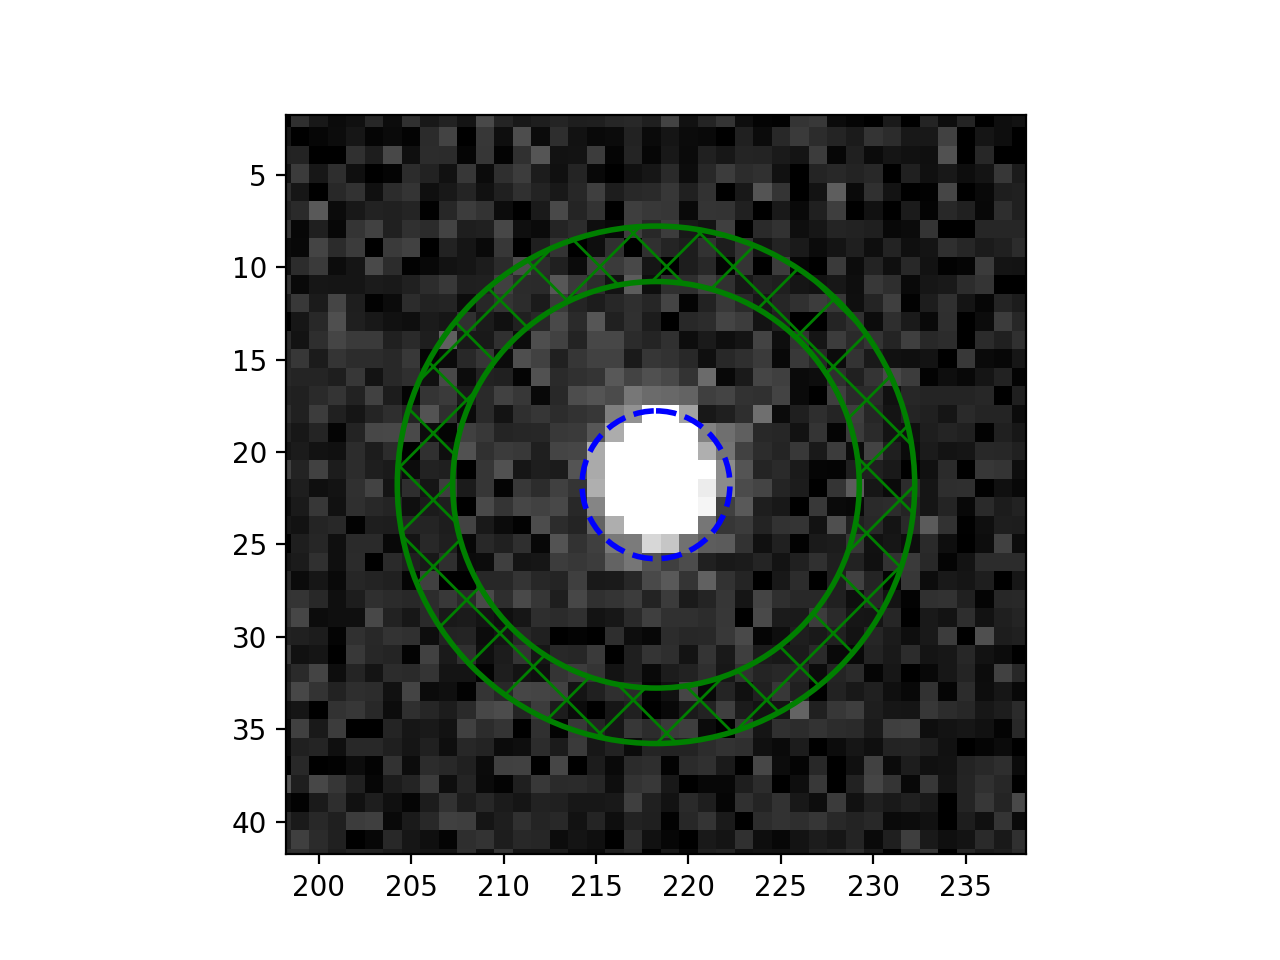

In [7]:
# So we want to perform aperture photometry around the detected star centers
# Let's first show what an example aperture looks like:

# display the image
plt.figure(3) #Create new "figure" for this image
# Use different vmin/vmax to get better contrast
plt.imshow(firstframe,cmap='gray',vmin=np.percentile(firstframe,10),
           vmax=np.percentile(firstframe,99.9))

# Put star centroid positions in format for aperture photometry
positions = [(x,y) for x,y in sources['xcentroid','ycentroid']]

# Define an example circular aperture of radius 4 pixels
ap = CircularAperture(positions,r=4)
ap.plot(color='blue',linestyle='--',lw=2)

# Define sky annulus in range 11-14 pixel radius
skyan = CircularAnnulus(positions,r_in=11,r_out=14)
skyan.plot(color='green',hatch='x',lw=2)

# Set limits to plot only around one star for demonstration
plt.xlim(x0-20,x0+20)
plt.ylim(y0+20,y0-20)
plt.show()

Looks good. But we still have to actually perform the aperture photometry. What this means is that we are going to sum the pixel values in each aperture (or annulus) and use those values to determine the brightness of the target relative to the comparison star. The comments in the cell below explain each step in more detail.

<mark>Q2: Name two ways that the counts in the undivided light curves might change.</mark>

In [8]:
# Sum the pixel values in each aperture (target and comparison) and sky annuli
starapsum = ap.do_photometry(firstframe)[0]
print("Aperture sums: ",starapsum)

skysum = skyan.do_photometry(firstframe)[0]
print("Sky sums: ",skysum)

# But we don't just want the total counts in each aperture...
# We want the average sky counts from the sky annuli which we will use to
# subtract the sky counts from the star aperture counts.

# The area() call returns the aperture areas, which we can use to correct
# for the background.
if PMA_macs:
    averagesky = skysum/skyan.area()
else:
    averagesky = skysum/skyan.area

print("Average sky counts: ",averagesky)

# Then use this average to subtract the expected contribution from the sky
# to the star apertures:
if PMA_macs:
    starsum = starapsum - ap.area()*averagesky
else:
    starsum = starapsum - ap.area*averagesky

print("Star sums in aperture: ",starsum)

# Finally, we want to divide counts of the target star by the counts from
# the comparison star to correct for changes in observing conditions.
rel_flux = starsum[0] / starsum[1]
print("Relative flux of target: ",rel_flux)

Aperture sums:  [ 82160.33458565 104666.83292811]
Sky sums:  [75890.83836942 75573.16537512]
Average sky counts:  [322.09072165 320.74247559]
Star sums in aperture:  [65970.28906684 88544.55764808]
Relative flux of target:  0.74505187917975


That's all there is to it! For that one single frame...

Now we need to perform aperture photometry on *all* of the science frames (with each aperture size) to construct a "light curve."

We provide the code for this, but picking the best aperture and writing the final light curve to a file is up to you!

We'll first set up the Numpy array that will hold all of the output photometry in the next cell. You need to modify the glob command to locate your full, ordered list of *reduced* science frames!

In [9]:
# Get list of reduced filenames (you may need to modify this)
filenames = sorted(glob('ktwo220274129/ktwo220274129-*[0-9]c.fits'))
n_frames = len(filenames)

# Verify from the first few filenames that these are the reduced
# frames and are listed in order.
print(filenames[:4])
if n_frames != 2161:
    print("WARNING: your glob call returns the wrong number of files!")

# Remember the aperture sizes we will test:
print("Aperture sizes (in pixels) to test:",apsizes)
n_apers = apsizes.shape[0]

# And we have 2 stars that we are measuring:
n_stars = 2

# To hold all of our results, we set up a 3-dimensional numpy array
# with dimensions (n_apers x n_stars x n_frames):
photresults = np.zeros((n_apers,n_stars,n_frames))

print("Photometry results will have shape",photresults.shape)

# You need to index this array in the same order, so the first index
# selects the aperture size, the next index selects the star (target
# at index 0; comp star at index 1), and frame number is last.

['ktwo220274129/ktwo220274129-0001c.fits', 'ktwo220274129/ktwo220274129-0002c.fits', 'ktwo220274129/ktwo220274129-0003c.fits', 'ktwo220274129/ktwo220274129-0004c.fits']
Aperture sizes (in pixels) to test: [2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9. ]
Photometry results will have shape (15, 2, 2161)


We're finally ready to do all the photometry!  Cross your fingers and **watch the figure** produced by the next cell as the photometry is performed.  This will take many minutes, but watching the photometry be performed can help avoid problems that might otherwise be missed if you only inspected the end product.

Note that the target and comparison stars will probably be misidentified many times throughout the run. Don't worry, we are doing our best to not include results from these frames in the final array.

<mark>Q3: Did you notice anything interesting between frames 460 and 490? Pay attention near the comparison star.  What do you think caused this?  How fast is this feature moving on the sky (in arcseconds/second)?</mark>

<IPython.core.display.Javascript object>


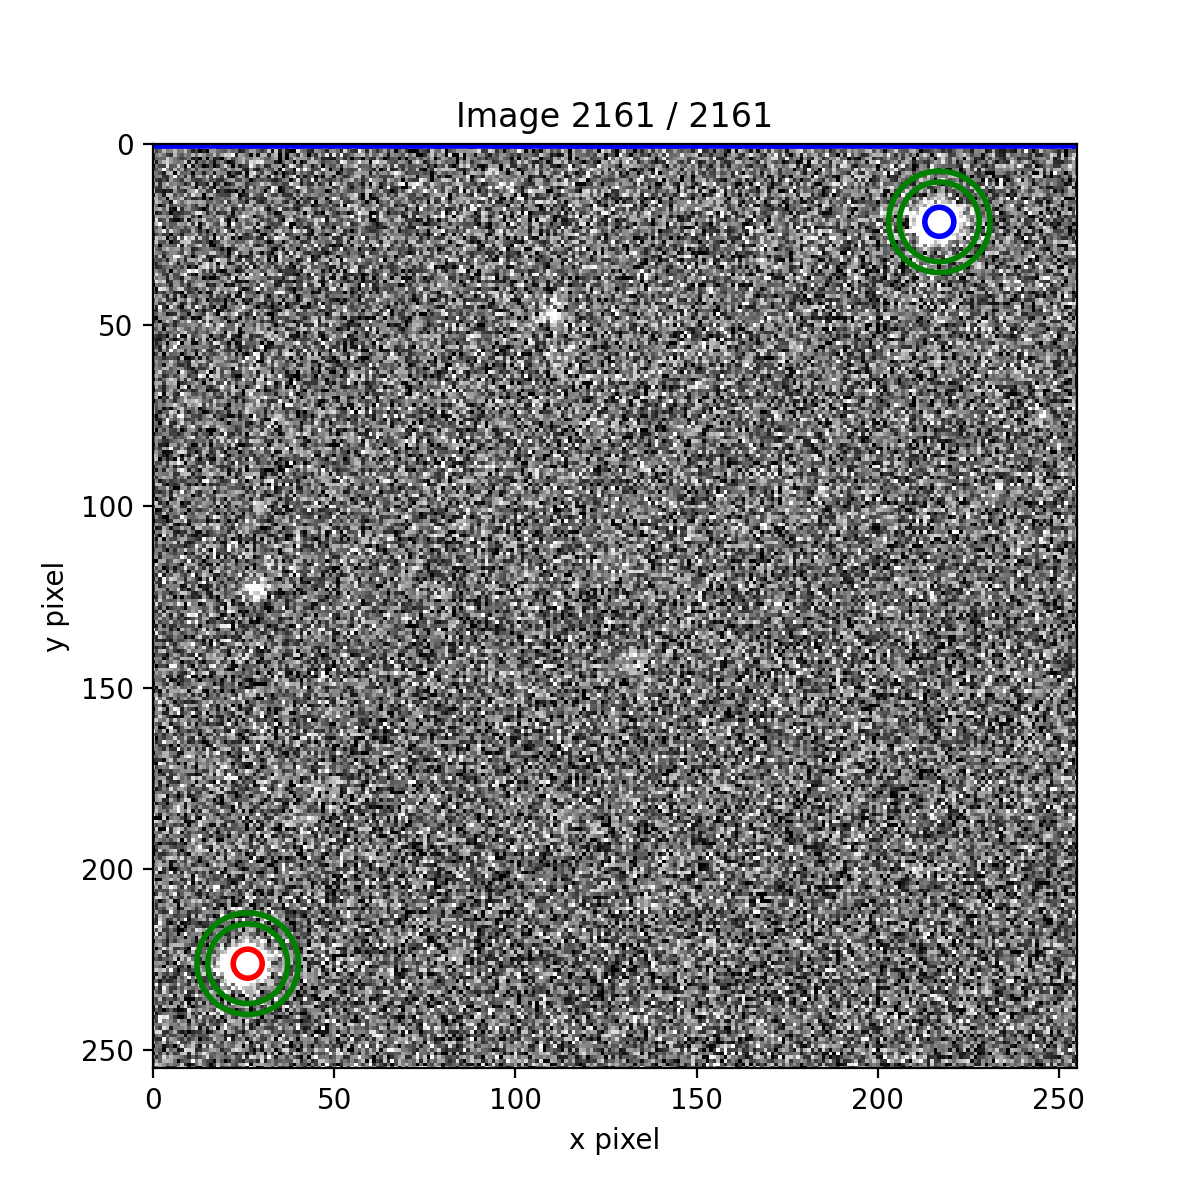

No sources found in frame  ktwo220274129/ktwo220274129-0997c.fits


No sources found in frame  ktwo220274129/ktwo220274129-1052c.fits


In [10]:
# We want to show a lot of plots together as we do the photometry.
# Set those up first.

# Visualize frames as we do photometry
fig = plt.figure(4,figsize=(6,6))

# First plot (upper left) displays images with apertures/annulli
ax1 = plt.subplot()
ax1.set_xlim(0,255)
ax1.set_xlabel("x pixel")
ax1.set_ylim(255,0)
ax1.set_ylabel("y pixel")
ax1.set_title("Image {} / {}".format(0,n_frames))
showframe = ax1.imshow(np.zeros((256,256)),cmap='gray')

# Set up circles to indicate apertures used
targetap = plt.Circle((0, 0), 4, color='b',fill=False,lw=2)
targetan1 = plt.Circle((0, 0), 11, color='g',fill=False,lw=2)
targetan2 = plt.Circle((0, 0), 14, color='g',fill=False,lw=2)
compap = plt.Circle((0, 0), 4, color='r',fill=False,lw=2)
compan1 = plt.Circle((0, 0), 11, color='g',fill=False,lw=2)
compan2 = plt.Circle((0, 0), 14, color='g',fill=False,lw=2)
ax1.add_artist(targetap)
ax1.add_artist(targetan1)
ax1.add_artist(targetan2)
ax1.add_artist(compap)
ax1.add_artist(compan1)
ax1.add_artist(compan2)


# We'll also set up empty lists to hold seeing and sky brightness
skybrightness = []
fwhm = []

for i,filename in enumerate(filenames):
#for i,filename in enumerate(filenames[990:1000]):
    # load the data
    frame = fits.getdata(filename)
    
    # display the image
    showframe.set_data(frame)
    showframe.set_clim(vmin=np.percentile(frame,5),vmax=np.percentile(frame,98))
    #ax1.imshow(frame,cmap='gray',vmin=np.percentile(frame,5),vmax=np.percentile(frame,98))
    ax1.set_title("Image {} / {}".format(i+1,n_frames))
    
    # First thing we need to know is how much scatter is in the "background"
    # counts so that we don't detect random background fluctuations as stars.
    bkg_sigma = mad_std(frame)

    # We also need to guess the full-width at half maximum (FWHM) for the 
    # stars to guide our search, which we will verify in a later step.
    daofind = DAOStarFinder(fwhm=1.2, threshold=5.*bkg_sigma)
    sources = daofind(frame) 
    
    
    # Set up empty arrays to hold distances of detections from approximate locations
    if sources is None:
        numsources = 0
        print('No sources found in frame ',filename)
    else:
        numsources = len(sources)
    
    # Sometimes no sources or the wrong sources are found.  Ignore those.
    if numsources == 0:
        photresults[:,:,i] = np.nan # replace missing values with "not a number"
        fwhm.append(np.nan)
    else:
        
        tdist = np.zeros(numsources)
        cdist = np.zeros(numsources)
        # Populate arrays with distances for each source
        for ii,row in enumerate(sources):
            tdist[ii] = distance(tx,ty,row["xcentroid"],row["ycentroid"])
            cdist[ii] = distance(cx,cy,row["xcentroid"],row["ycentroid"])
    
        # "Typical background"
        bkgmed = np.median(frame.flatten())
        skybrightness.append(bkgmed)
    
        # Identify the row indices of the target and comp stars in "sources"
        tind = np.argmin(tdist)
        cind = np.argmin(cdist)
        # Replace "sources" with just target and comparison, in that order:
        sources = sources[[tind,cind]]

        x0 = sources['xcentroid'][0] # x center of target star
        y0 = sources['ycentroid'][0] # y center of target star
        dist = [] #empty list to hold pixel distances
        pval = [] #empty list to hold pixel values
        for x in np.arange(max([round(x0)-pdist,0]),min([round(x0)+pdist,255])):
            for y in np.arange(max([round(y0)-pdist,0]),min([round(y0)+pdist,255])):
                dist.append(distance(x,y,x0,y0))
                pval.append(frame[int(y),int(x)])


        p0=[15000.,1.] #initial guesses of height and sigma
        popt,_  = curve_fit(gaussian,dist,np.array(pval)-bkgmed,p0=p0)
        fwhm.append(np.abs(popt[-1])*2.3548*platescale)


        # Put star centroid positions in format for aperture photometry
        positions = [(x,y) for x,y in sources['xcentroid','ycentroid']]
        # Center aperture markers on centroids
        targetap.center = positions[0]
        targetan1.center = positions[0]
        targetan2.center = positions[0]
        compap.center = positions[1]
        compan1.center = positions[1]
        compan2.center = positions[1]

        # Loop through the different aperture sizes we want to try
        # and save the photometry.
        for j,apsize in enumerate(apsizes):
            # Define an example circular aperture of radius apsize pixels
            ap = CircularAperture(positions,r=apsize)
            # Define sky annulus in range 11-14 pixel radius
            skyan = CircularAnnulus(positions,r_in=11,r_out=14)
            # Do the photometry
            starapsum = ap.do_photometry(frame)[0]
            skysum = skyan.do_photometry(frame)[0]
            if PMA_macs:
                averagesky = skysum/skyan.area()
                starsum = starapsum - ap.area()*averagesky
            else:
                averagesky = skysum/skyan.area
                starsum = starapsum - ap.area*averagesky
            # Store the results!
            photresults[j,:,i] = starsum
            
        # If found centroid too far from expected, replace with np.nan
        if np.min(tdist) > 3:
            photresults[:,0,i] = np.nan
            fwhm[-1] = np.nan
        if np.min(cdist) > 3:
            photresults[:,1,i] = np.nan
        
    # Manually delete the image data to free up memory
    del frame
    gc.collect()
    
    # Update the figure
    fig.canvas.draw()

## Time for you to take over

The star-finding algorithm isn't the best, and you probably noticed it identifying the wrong parts of the images as stars occasionally.  We tried to identify when that was happening and replace those values in the photometry array with np.nan, which stands for "not a number," and is not displayed when plotted.  However, you may need to use special numpy features when characterizing slices of this array, like np.nanmin() instead of np.min, and np.nanmean instead of np.mean(), etc.

What you need to decide is: which aperture yields the highest quality light curve?  To choose, plot the divided light curves (summed target flux / summed comparison star flux) for each aperture size. With the "%matplotlib notebook" command, you can use tools to zoom in and inspect plots in more detail; just remember to call the plt.figure() command before starting a new plot.

<mark>Q4: Why do we *divide* the target counts by the comparison counts?</mark>

<mark>Q5: Why do we use the same aperture size for both the target and comparison stars?</mark> (Note: you're not expected to know the answers to all of these. Just think about it and respond the best you can.)

There are likely a couple "outlier" points that don't fit the trend of the rest of the data.  Try to replace these with np.nan values by applying a cut on the data (using np.where() or loops and if statements).  These outliers will cause problems in next week's lab if you don't get rid of them now.

<mark>Q6: What aperture size produced the best light curve?</mark>

<mark>Q7: Save a plot of your divided light curve for your best aperture and attach it to the quiz.</mark>

Also make and submit a plot of the seeing (as measured in FWHM for the target star, recorded in the last step). 

<mark>Q8: Did the seeing get generally better or worse through the duration of this run?</mark>

The important last step is to **save a text file with your divided light curve**, normalized so that its mean value is 1.0; remember the name and location of this file because you will need it to do next week's lab. The first column of this data file should contain the relative time of each frame (0,10,20,..., since this is a sequence of 10-second exposures), and the second column should contain the divided, normalized light curve after removing obvious outliers.  *DO NOT* include the nan values in the output, but be sure to account for them when constructing the "time" column.  np.savetxt() may be useful.

<mark>Q9: Upload a **completed PDF copy** of this Jupyter Notebook.</mark>

2.0


<IPython.core.display.Javascript object>

2.5


<IPython.core.display.Javascript object>


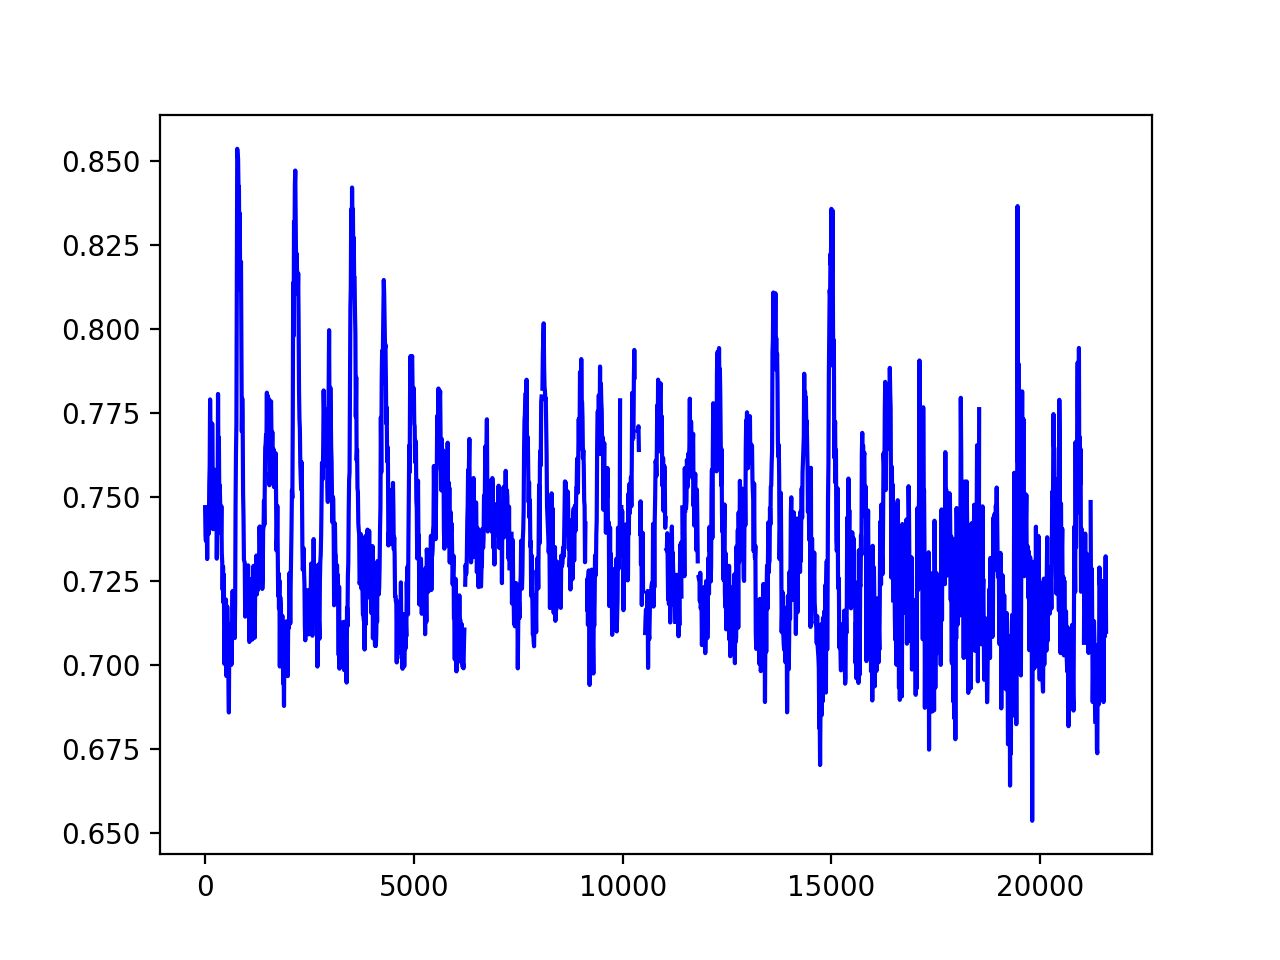

3.0


<IPython.core.display.Javascript object>


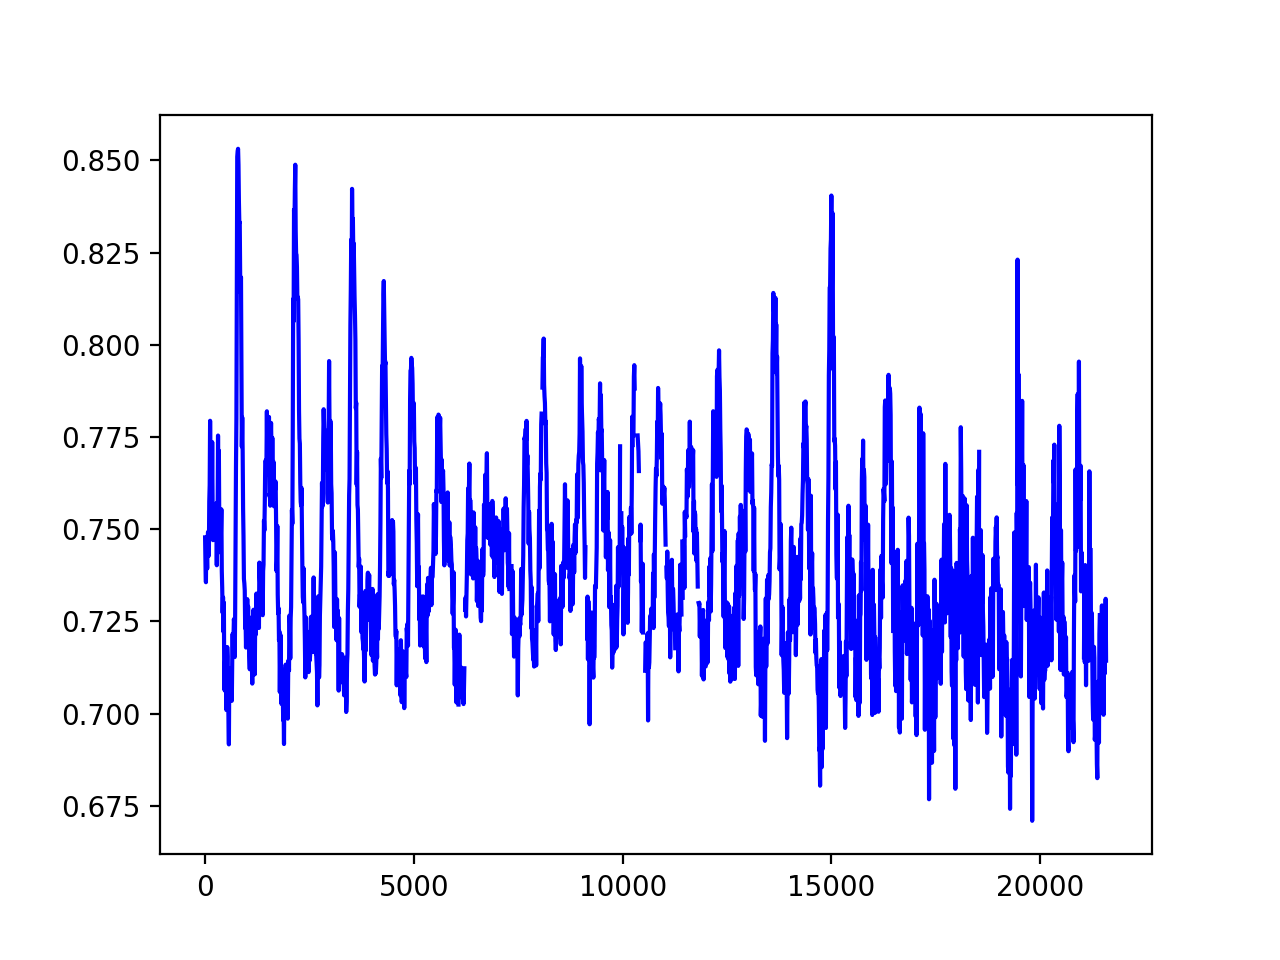

3.5


<IPython.core.display.Javascript object>


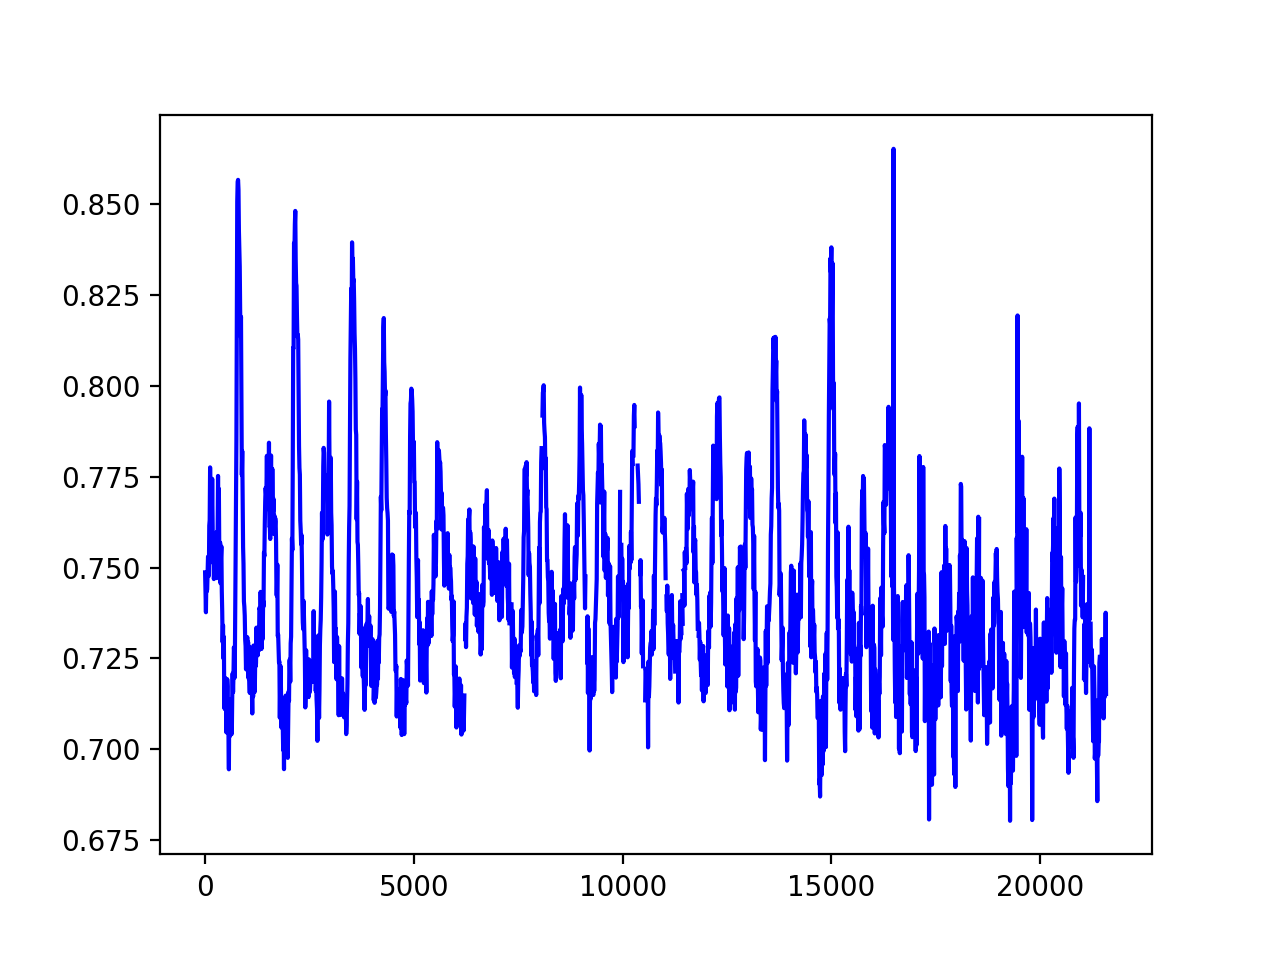

4.0


<IPython.core.display.Javascript object>


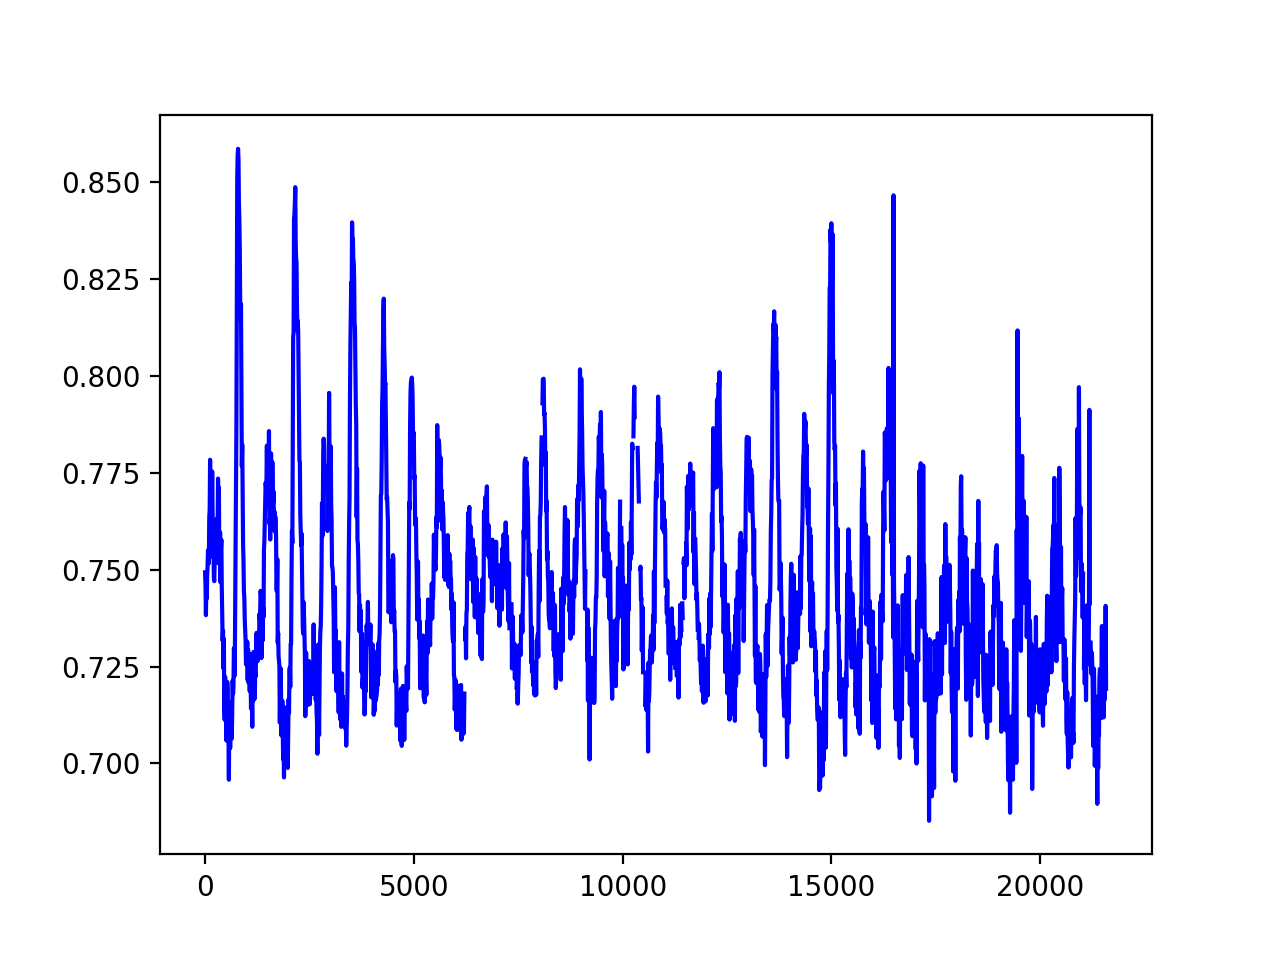

4.5


<IPython.core.display.Javascript object>


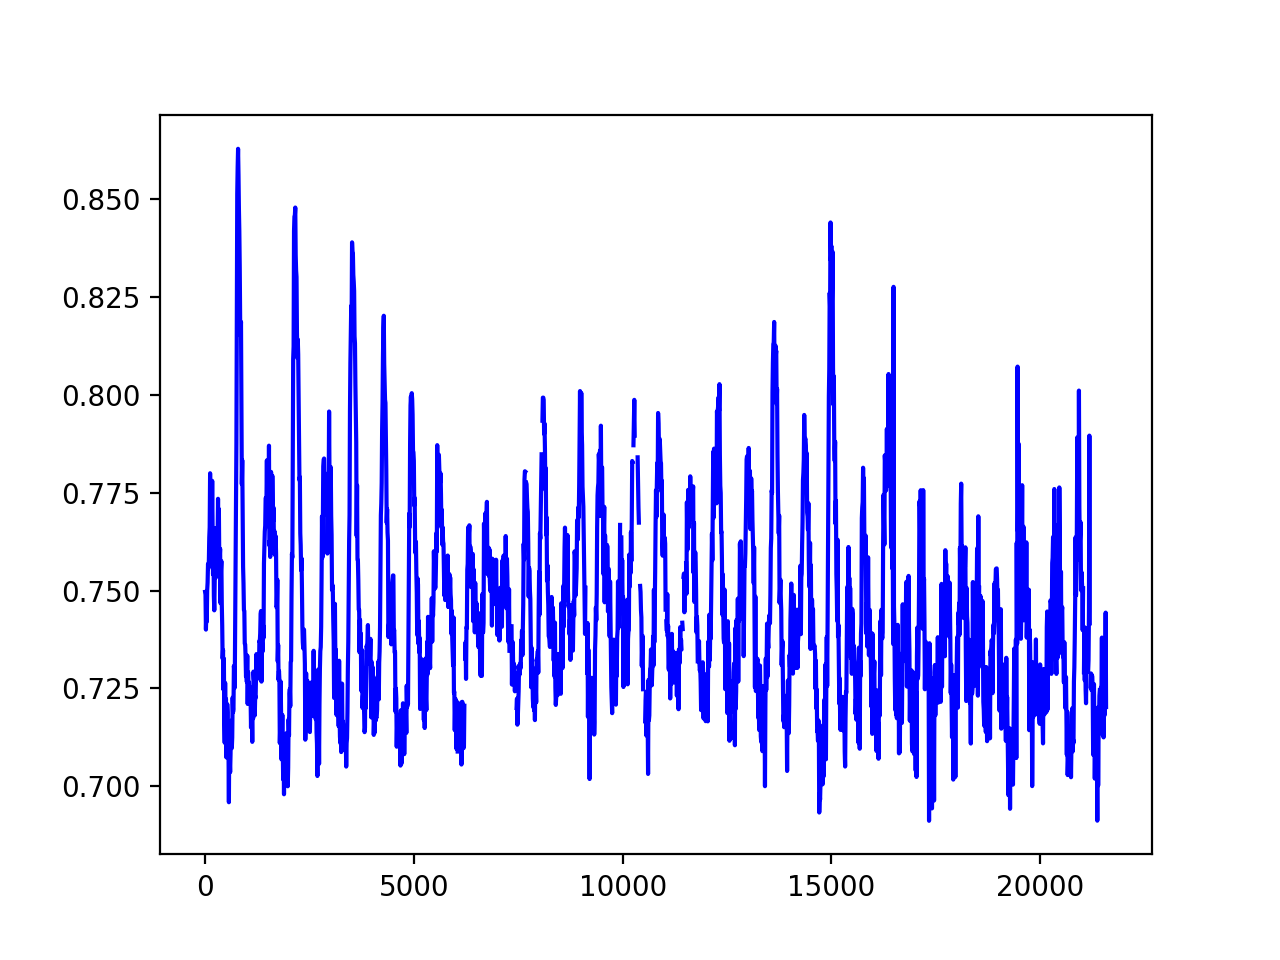

5.0


<IPython.core.display.Javascript object>


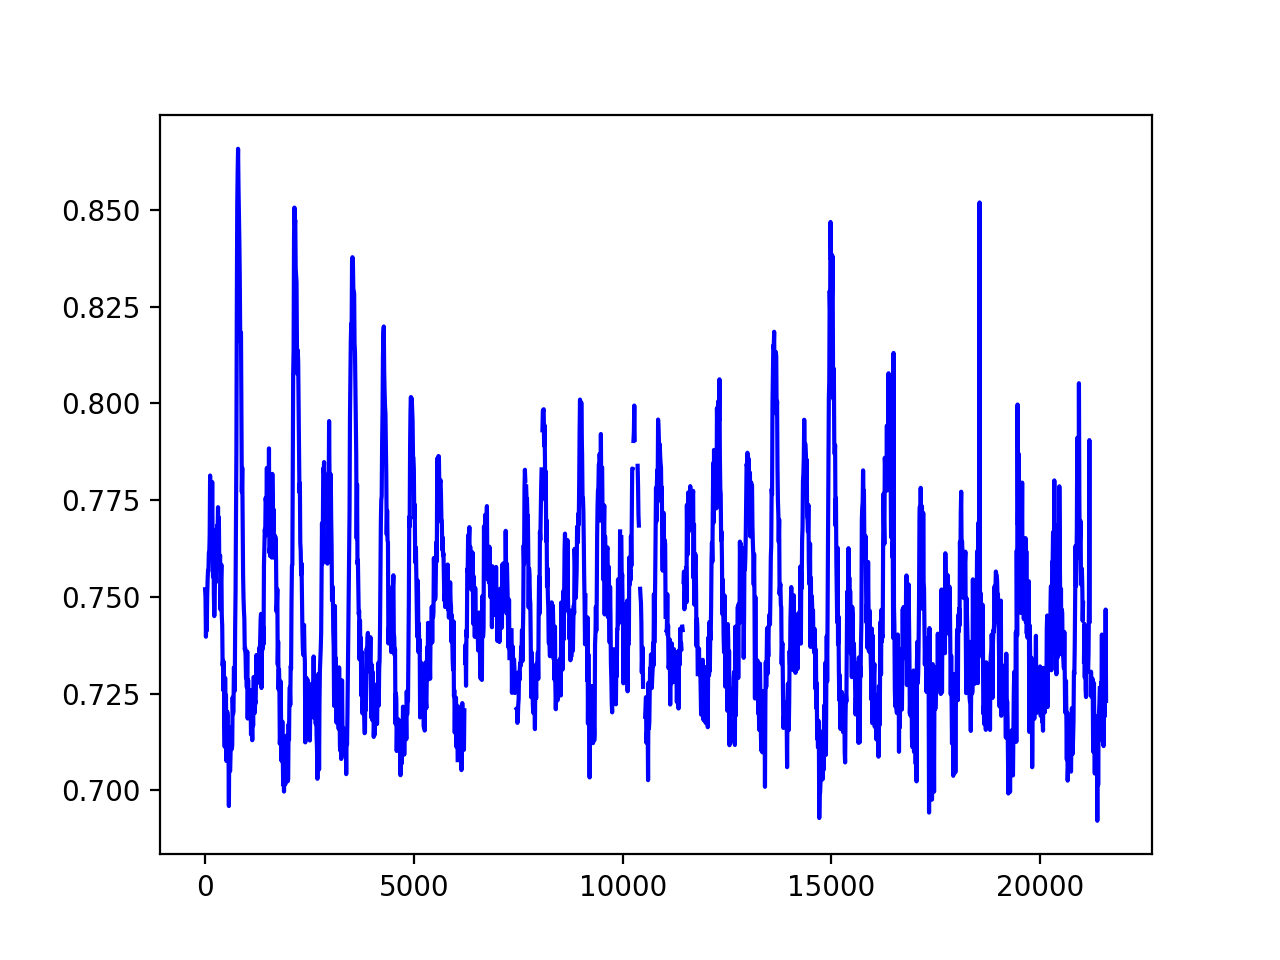

5.5


<IPython.core.display.Javascript object>


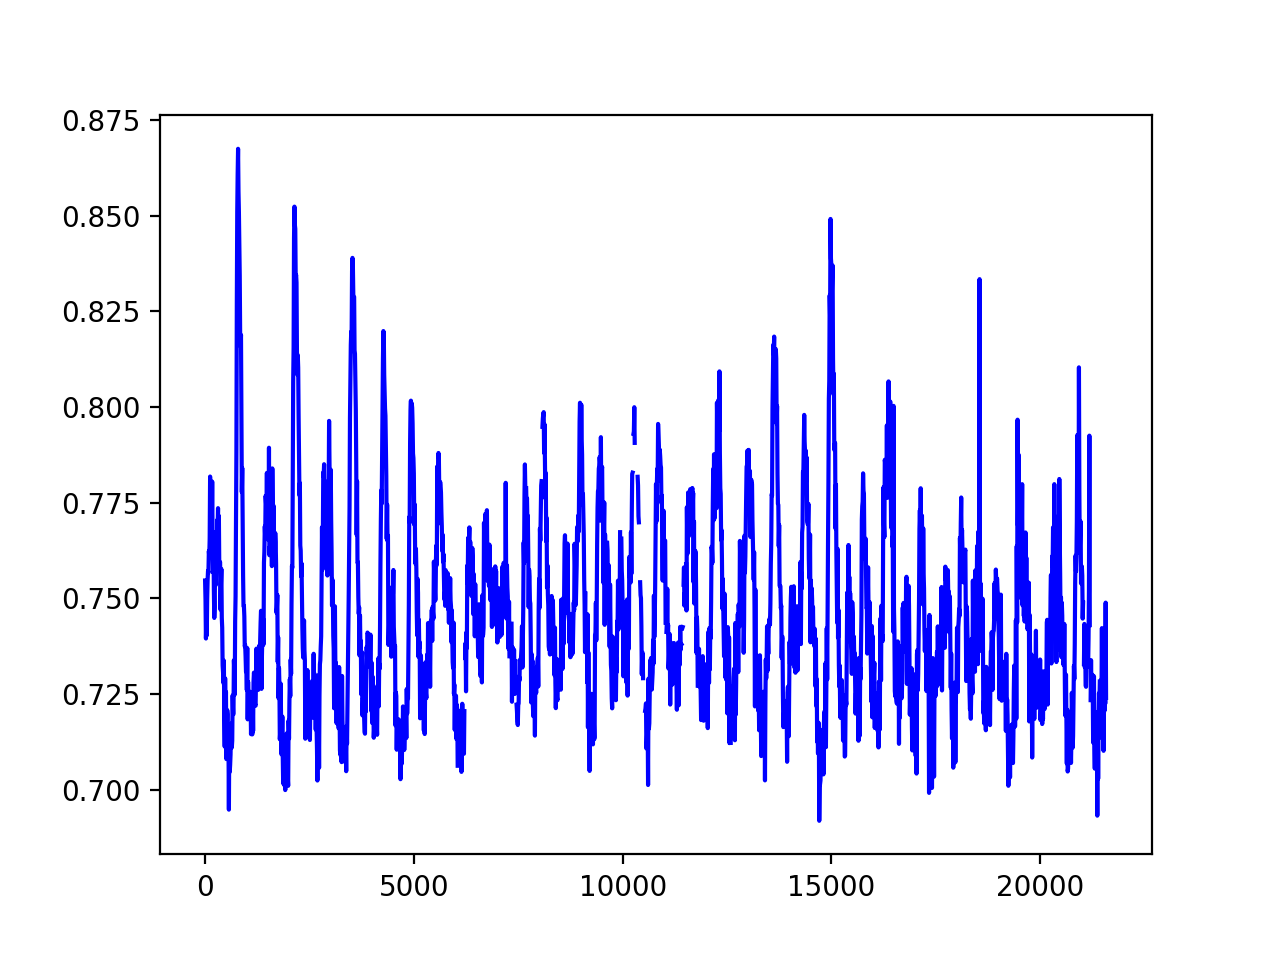

6.0


<IPython.core.display.Javascript object>


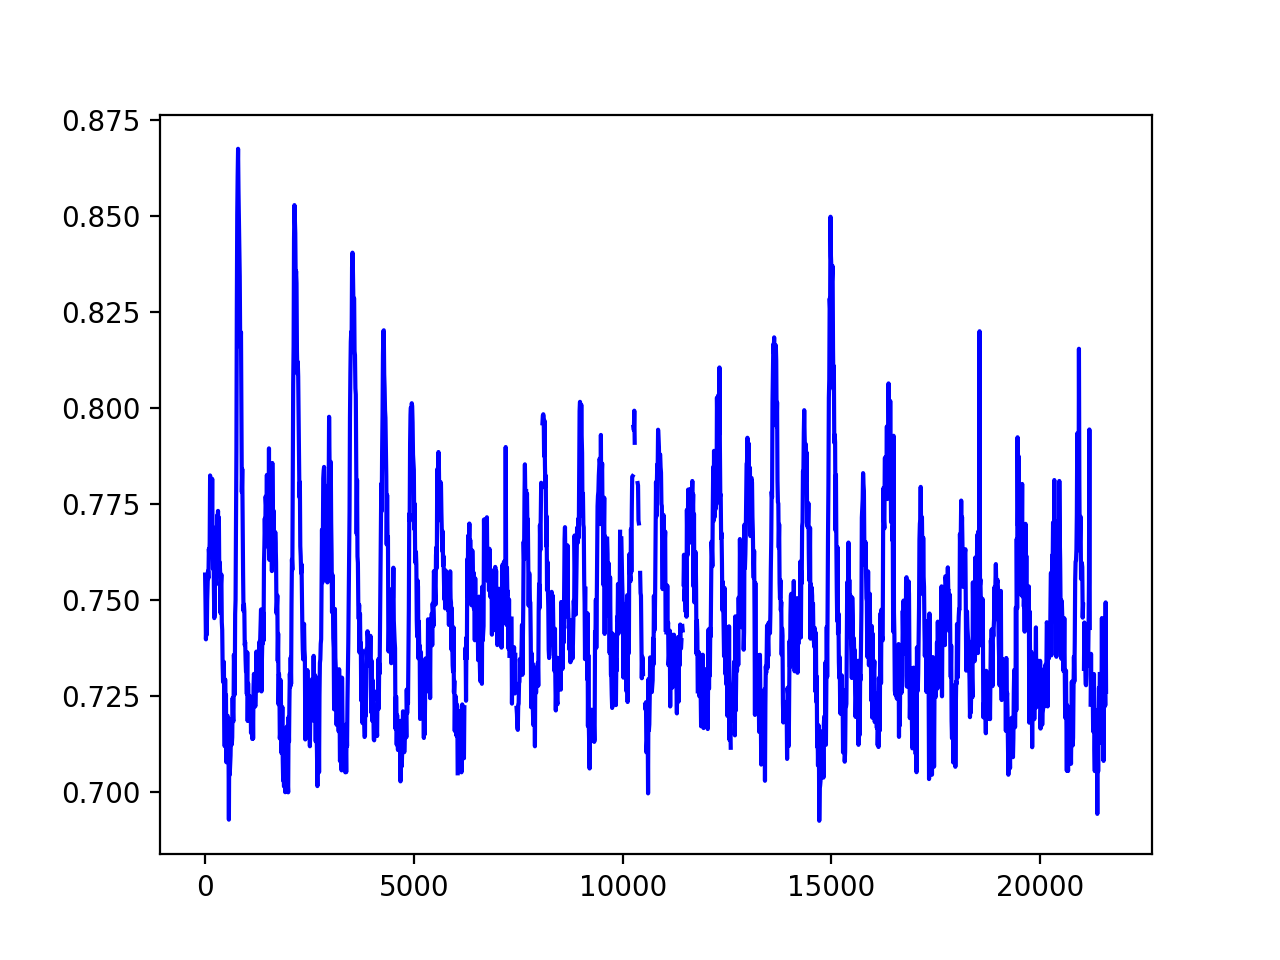

6.5


<IPython.core.display.Javascript object>


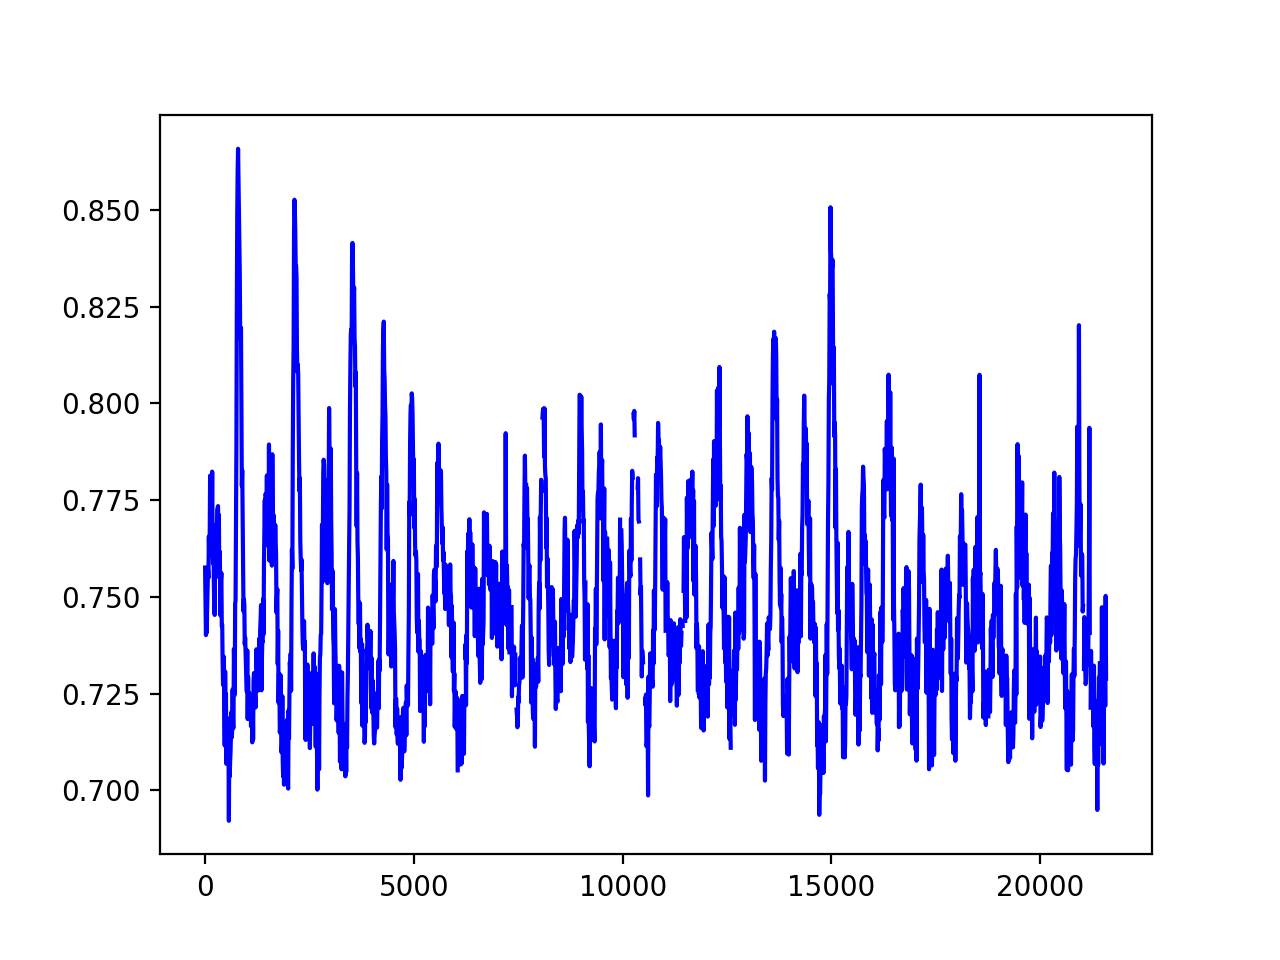

7.0


<IPython.core.display.Javascript object>


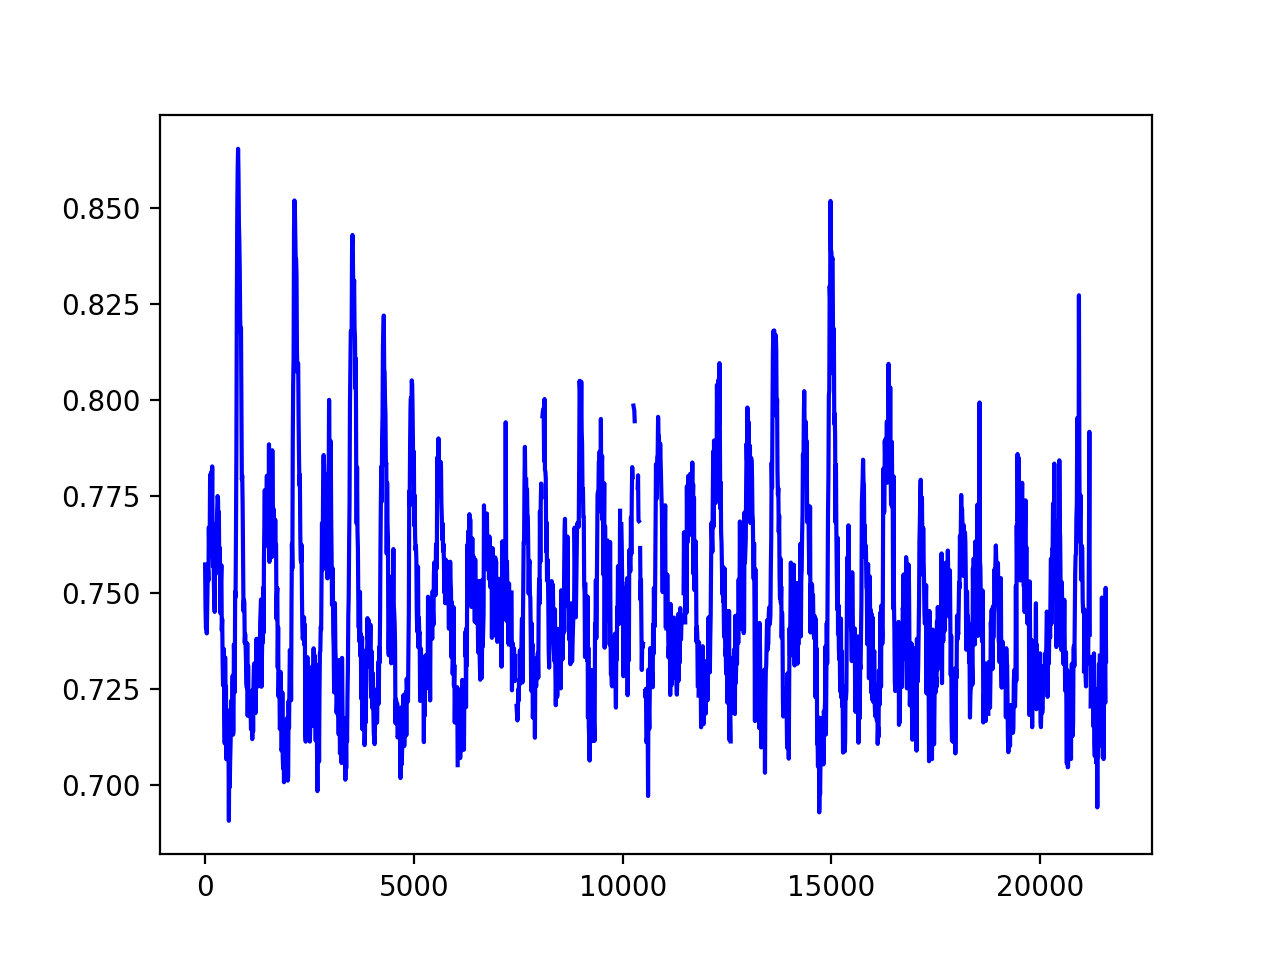

7.5


<IPython.core.display.Javascript object>

8.0


<IPython.core.display.Javascript object>

8.5


<IPython.core.display.Javascript object>


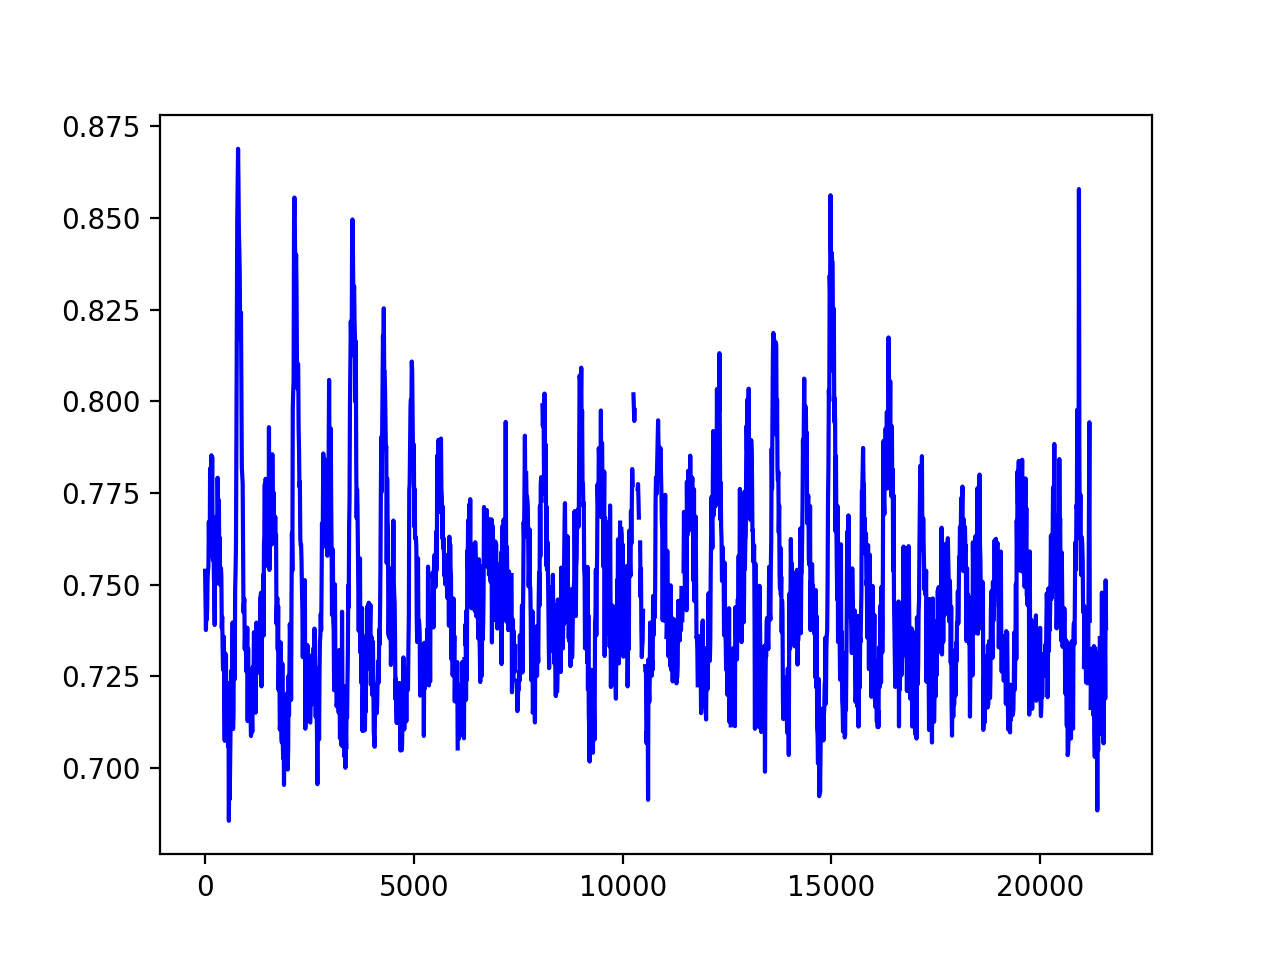

9.0


<IPython.core.display.Javascript object>


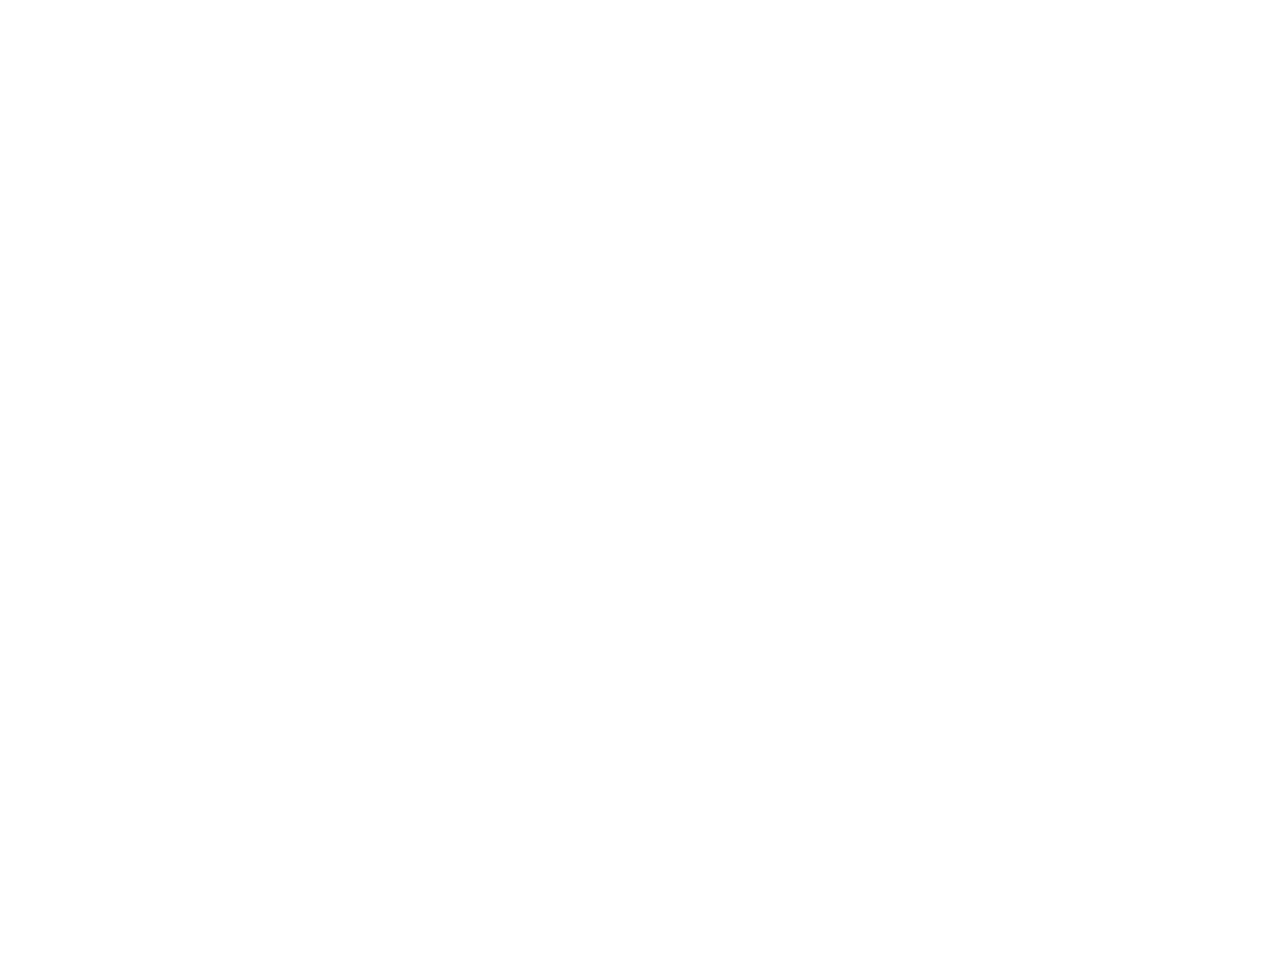

In [11]:
for i in range(len(apsizes)):
    new_phot_results = photresults[i,0,:]/photresults[i,1,:]
    t = range(0,21610,10)
    print(apsizes[i])
    for j in range(len(new_phot_results)):
        if new_phot_results[j]>.875:
            new_phot_results[j]=np.nan
    plt.plot(t, new_phot_results, c='blue')
    plt.figure()
    plt.show()

<IPython.core.display.Javascript object>


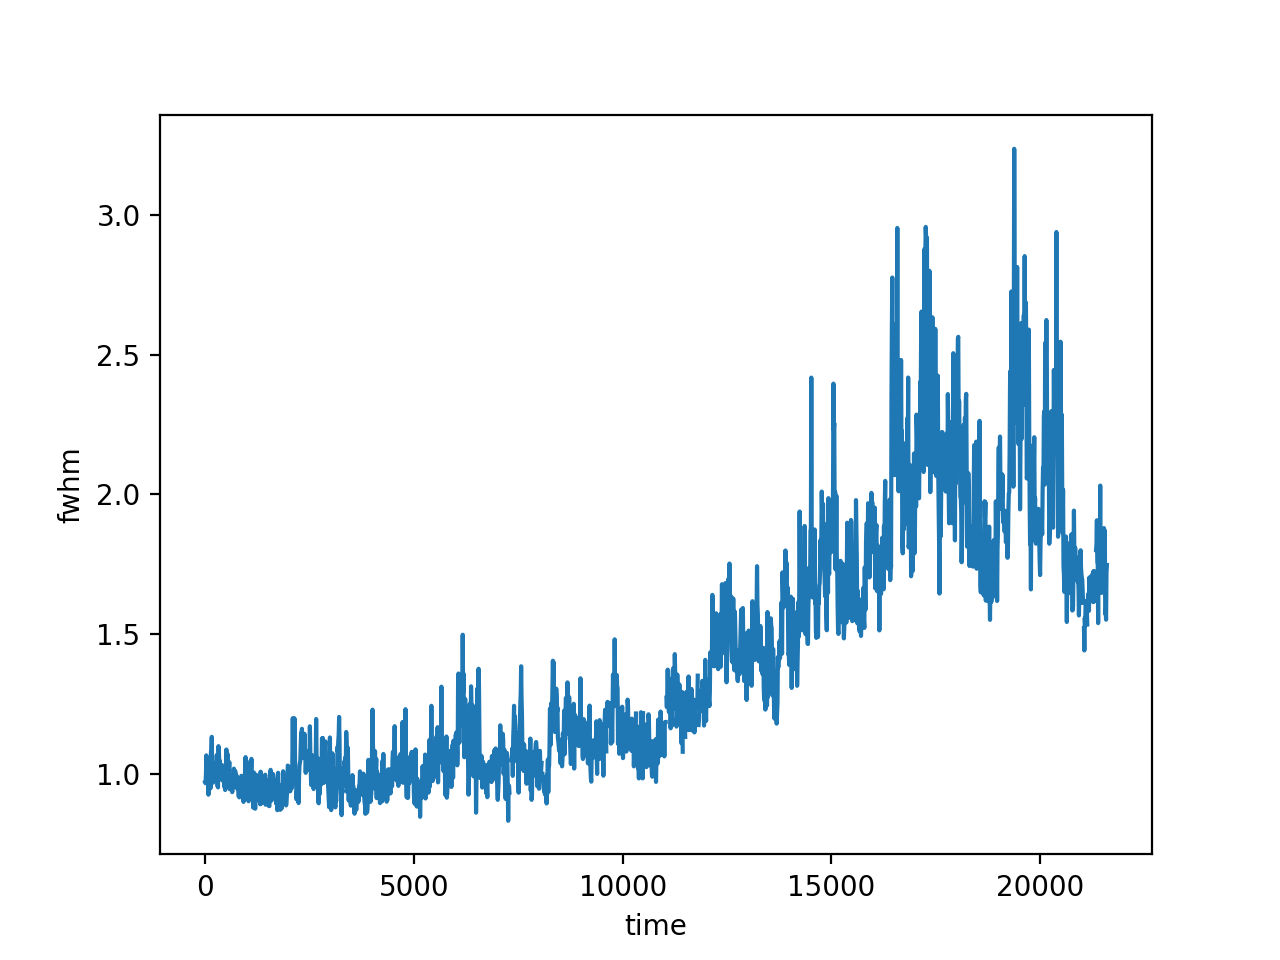

In [12]:
plt.figure()
plt.plot(t, fwhm)
plt.xlabel("time")
plt.ylabel("fwhm")
plt.show()

In [34]:
print(np.ndim(new_phot_results))
array = np.column_stack((t, new_phot_results))
print(array[:][:])
np.savetxt("DLC.txt", array)


1
[[0.00000000e+00 7.53793185e-01]
 [1.00000000e+01 7.45234089e-01]
 [2.00000000e+01 7.37640199e-01]
 ...
 [2.15800000e+04 7.38171110e-01]
 [2.15900000e+04            nan]
 [2.16000000e+04 7.30010595e-01]]
